In [14]:
# relevant imports

# base
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# data prep
from sklearn import preprocessing
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from scipy import stats

# nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

# import metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, average_precision_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, log_loss, precision_recall_curve
# !pip install seaborn
import seaborn as sn
import pandas as pd

# import matplotlib
import matplotlib.pyplot as plt

# uncomment !pip install commands if you get an error

In [15]:
# import data
df = pd.read_csv("./ks-projects-201801.csv")

In [16]:
df.shape

(378661, 15)

In [17]:
# number of campaigns to begin with
orig_num_campaigns = len(df)

In [18]:
df

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00


In [19]:
# keep only campaigns that were successful or failed
df1 = df
df1['state_string'] = [str(state) for state in df1['state']]
df1 = df1[(df.state_string == 'successful') | (df1.state_string == 'failed')]
df1 = df1.drop(['state_string'], axis=1)

In [20]:
# number of campaigns either successful or failed
new_num_campaigns = len(df1)

In [21]:
print("Number of Campaigns before filtering for successful/failed: ", orig_num_campaigns)
print("Number of Campaigns after filtering for successful/failed: ", new_num_campaigns)
print("% of data lost: ", abs(new_num_campaigns - orig_num_campaigns)/orig_num_campaigns*100)

Number of Campaigns before filtering for successful/failed:  378661
Number of Campaigns after filtering for successful/failed:  331675
% of data lost:  12.408460337874775


Text(0,0.5,'Number of Campaigns')

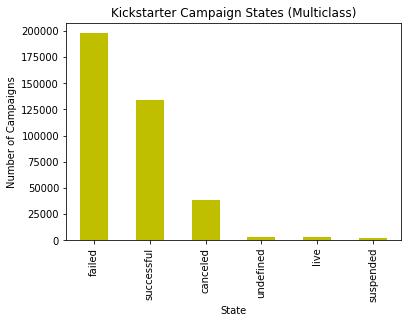

In [22]:
ax1 = df['state'].value_counts().plot(kind='bar', title="Kickstarter Campaign States (Multiclass)", color='y')
ax1.set_xlabel('State')
ax1.set_ylabel('Number of Campaigns')

Text(0,0.5,'Number of Campaigns')

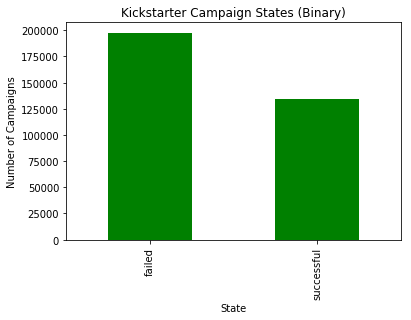

In [23]:
ax2 = df1['state'].value_counts().plot(kind='bar', title="Kickstarter Campaign States (Binary)", color='g')
ax2.set_xlabel('State')
ax2.set_ylabel('Number of Campaigns')

Text(0,0.5,'Number of Campaigns')

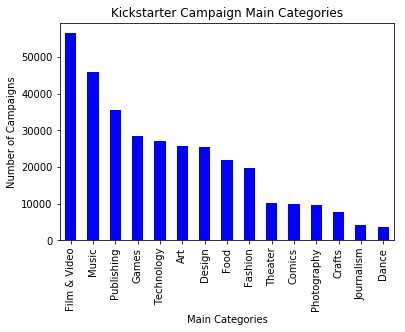

In [24]:
ax3 = df1['main_category'].value_counts().plot(kind='bar', title="Kickstarter Campaign Main Categories", color='b')
ax3.set_xlabel('Main Categories')
ax3.set_ylabel('Number of Campaigns')

In [25]:
# MAJORITY VOTE CLASSIFICATION - prob not gonna do it
unique, counts = np.unique(df1['state'], return_counts=True)
print("original states and counts")
print(unique[0] + ": " + str(counts[0]))
print(unique[1] + ": " + str(counts[1]))
print(counts[0]/(counts[0]+counts[1]))

original states and counts
failed: 197719
successful: 133956
0.5961227104846611


In [26]:
# import feature data - make sure csv files are in the same directory
x_train = pd.read_csv("./x_train.csv")
x_val = pd.read_csv("./x_val.csv")

In [27]:
# import state data => no header, so you have to specify header=None
y_name = ["state"]
y_train = pd.read_csv("./y_train.csv", names=y_name, header=None)
y_val = pd.read_csv("./y_val.csv", names=y_name, header=None)

In [28]:
# MAJORITY VOTE CLASSIFICATION - prob not gonna do it
unique, counts = np.unique(y_val, return_counts=True)
print("y_val states and counts")
print(unique[0] + ": " + str(counts[0]))
print(unique[1] + ": " + str(counts[1]))

y_val states and counts
failed: 39621
successful: 26714


In [29]:
# turn object into category
y_train['state'] = y_train['state'].astype('category')
y_val['state'] = y_val['state'].astype('category')
# flatten 1-column dataframe into series
y_train = y_train['state']
y_val = y_val['state']

In [30]:
# DUMMY CLASSIFIER FROM SCIKIT-LEARN
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()
clf.fit(x_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [31]:
# predictions and probabilities
predictions = clf.predict(x_val)
probabilities = clf.predict_proba(x_val)
training_predictions = clf.predict(x_train)

In [32]:
# training and validation accuracy
print ("Training Accuracy: ", accuracy_score(y_train, training_predictions))
print ("Validation Accuracy: ", accuracy_score(y_val, predictions))
# training and validation balanced accuracy
print ("Training Balanced Accuracy: ", balanced_accuracy_score(y_train, training_predictions))
print ("Validation Balanced Accuracy: ", balanced_accuracy_score(y_val, predictions))

Training Accuracy:  0.5211778598527675
Validation Accuracy:  0.5177357352830331
Training Balanced Accuracy:  0.5028293570379165
Validation Balanced Accuracy:  0.4989149219626342


Text(0.5,1,'Confusion Matrix - Dummy Classifier')

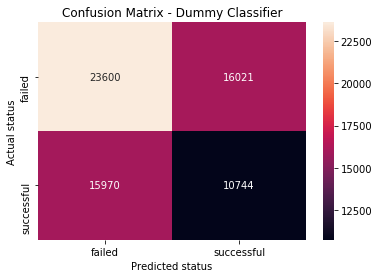

In [33]:
# best confusion matrix depiction using seaborn heatmap
cm = confusion_matrix(y_val, predictions)
class_names = y_val.unique()
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
fig = plt.figure()
heatmap = sn.heatmap(df_cm, annot=True, fmt="d")
plt.xlabel('Predicted status')
plt.ylabel('Actual status')
plt.title('Confusion Matrix - Dummy Classifier')

In [34]:
# classification report with relevant statistics
cr = classification_report(y_val, predictions)
print(cr)

              precision    recall  f1-score   support

      failed       0.60      0.60      0.60     39621
  successful       0.40      0.40      0.40     26714

   micro avg       0.52      0.52      0.52     66335
   macro avg       0.50      0.50      0.50     66335
weighted avg       0.52      0.52      0.52     66335



In [35]:
print("Log loss: ", log_loss(y_val, probabilities))

Log loss:  16.657858946293473


In [40]:
# get probabilities for the positive class (second column in probabilities)
positive_probabilities = probabilities[:,1]
# is over 0.5 - which is the standard for a no-skill model
print("ROC_AUC score: ", roc_auc_score(y_val, positive_probabilities))

ROC_AUC score:  0.499103085076915


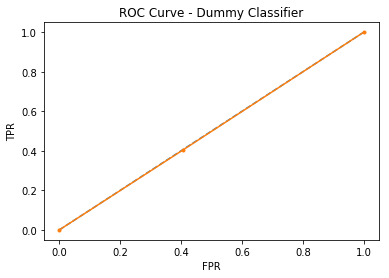

In [37]:
# our dataset is balanced - this one is better
# plot ROC curve
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
fpr, tpr, thresholds = roc_curve(y_val, positive_probabilities, pos_label="successful")
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title("ROC Curve - Dummy Classifier")
plt.xlabel("FPR")
plt.ylabel("TPR")
# show the plot
plt.show()

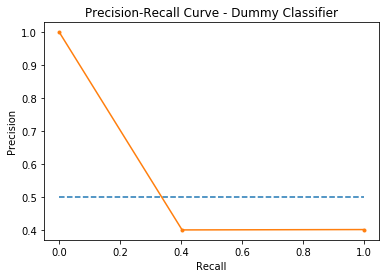

In [38]:
# plot precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val.cat.codes, positive_probabilities)
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
plt.title("Precision-Recall Curve - Dummy Classifier")
plt.xlabel("Recall")
plt.ylabel("Precision")
# show the plot
plt.show()

In [55]:
# baseline #2 - majority vote
unique, counts = np.unique(y_train, return_counts=True)

classes = np.asarray((unique, counts)).T
failed = classes[0][1]
successful = classes[1][1]
# pick failed because failed # is greater than success #

In [56]:
# baseline #2 - majority vote
unique, counts = np.unique(y_val, return_counts=True)

classes = np.asarray((unique, counts)).T
failed = classes[0][1]
successful = classes[1][1]

In [57]:
# always predict negative - only true and false negatives exist
tp = 0
fp = 0
tn = failed
fn = successful

In [82]:
accuracy = tn/(failed+successful)
print("Accuracy: ", accuracy)

Accuracy:  0.5972865003391875


In [88]:
y_predict = np.array(["failed"] * 66335, dtype=object)
probabilities = np.array([[1,0]]*66335)
probabilities

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

Text(0.5,1,'Confusion Matrix - Zero Rule Method')

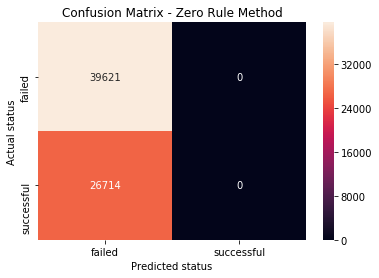

In [92]:
# best confusion matrix depiction using seaborn heatmap
cm = confusion_matrix(y_val, y_predict)
class_names = y_val.unique()
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
fig = plt.figure()
heatmap = sn.heatmap(df_cm, annot=True, fmt="d")
plt.xlabel('Predicted status')
plt.ylabel('Actual status')
plt.title('Confusion Matrix - Zero Rule Method')

In [89]:
# get probabilities for the positive class (second column in probabilities)
positive_probabilities = probabilities[:,1]
# is over 0.5 - which is the standard for a no-skill model
print("ROC_AUC score: ", roc_auc_score(y_val, positive_probabilities))

ROC_AUC score:  0.5


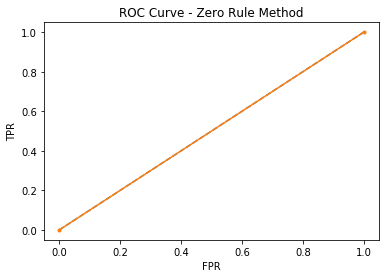

In [91]:
# our dataset is balanced - this one is better
# plot ROC curve
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
fpr, tpr, thresholds = roc_curve(y_val, positive_probabilities, pos_label="successful")
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title("ROC Curve - Zero Rule Method")
plt.xlabel("FPR")
plt.ylabel("TPR")
# show the plot
plt.show()